# 주제 : 영화 리뷰 텍스트 분석
----------

## 1.1 데이터셋 정보
    - 네이버 영화 페이지 중 '이스케이프 룸2 : 노 웨이 아웃' 관객들의 평점과 후기를 웹 스크래핑으로 수집한 데이터

### 1.1.1 Feature Description

* **score** : 관객 리뷰의 평가 점수
* **comment** : 관객 리뷰 평가 내용


### 1.1.2 데이터 출처

- https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=191548&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false

### 1.1.3 웹 크롤링 코드

In [ ]:
import requests
from bs4 import BeautifulSoup
from openpyxl import Workbook

wb = Workbook(write_only=True)
ws = wb.create_sheet('naver_movie_ratings')
ws.append(['score', 'comment'])

url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=191548&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=1'
response = requests.get(url)
review_page = response.text

soup = BeautifulSoup(review_page, 'html.parser')
total_count = soup.select('body > div > div > div.score_total > strong > em')
total_count = int(total_count[0].get_text())

for page in range(1,51):
    url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=191548&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page={}'.format(page)
    response = requests.get(url)
    review_page = response.text
    soup = BeautifulSoup(review_page, 'html.parser')

    for i in range(10):
        review = soup.find('span', {'id': '_filtered_ment_{}'.format(i)})
        review = review.get_text().strip()

        score = soup.select('body > div > div > div.score_result > ul > li:nth-child({}) > div.star_score > em'.format(i + 1))
        score = int(score[0].get_text())

        row = [score, review]
        ws.append(row)

wb.save('naver_movie_ratings.xlsx')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('naver_movie_ratings.xlsx')
df.head()

,score,comment
0,10,다음장면이 예상 가는데도 불구하고 상황이 빠르게 흘러가다 보니 긴장감이 넘칩니다.잔...
1,10,긴장감 최고요~~~어김없이 다음편도 살짝 보여줍니다. 3펀기대기대요
2,10,나였으면 시작하자 마자 죽었을 듯...새로운 인물의 출연이 몰입도를 깨는 일은 없다...
3,10,스릴러는 이렇게 만드는거지. 영화 끝날 때까지 끝난게아님. 이거 이스케이프룸1 안보...
4,10,속도감있어서 끝까지 시간가는줄 모르고 봤어요. 끝나고 화장실갔는데 화장실문이 안 열...


## 1.2 데이터셋 살펴보기

In [ ]:
df.shape

(500, 2)

In [ ]:
df.isnull().sum()

score       0
comment    18
dtype: int64

In [ ]:
df = df.dropna(axis=0).copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 0 to 499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    482 non-null    int64 
 1   comment  482 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


## 1.3 한국어 텍스트 데이터 전처리

In [ ]:
# konlpy 설치
!pip install konlpy==0.5.1 jpype1 Jpype1-py3

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 41.3 MB/s 
     |████████████████████████████████| 88 kB 6.9 MB/s 
  Created wheel for Jpype1-py3: filename=JPype1_py3-0.5.5.4-cp37-cp37m-linux_x86_64.whl size=2686695 sha256=1a692d493db3ba6a1eec49cfdd388b583fa71b782072d75e77ce46267751077f
  Stored in directory: /root/.cache/pip/wheels/e7/d1/09/f55dca0203b0691945bdf0f63d486a0b4d4e5ec4bd78a2502e
Successfully built Jpype1-py3


### 1.3.1 정규표현식 적용

In [ ]:
# 텍스트에서 한글만 추출하기(공백 문자는 하나만 포함) => 한글과 공백이 아닌 문자를 찾아서 모두 ''으로 치환
import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    return result

In [ ]:
apply_regular_expression(df['comment'][0])

'다음장면이 예상 가는데도 불구하고 상황이 빠르게 흘러가다 보니 긴장감이 넘칩니다잔인한 장면 못보시는 분들도 시청 가능영화 끝나고 상영관에서 나올때 문 안열릴까봐 긴장했는데 다행히 열리더라구요 그만큼 몰입감이 '

### 1.3.2 한국어 형태소 분석 - 명사 형태소 추출

In [ ]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()

# 명사만 추출하기 => Okt().nouns(text)
nouns = nouns_tagger.nouns(apply_regular_expression(df['comment'][0]))

In [ ]:
nouns

['다음',
 '장면',
 '예상',
 '불구',
 '상황',
 '긴장감',
 '장면',
 '분',
 '시청',
 '가능',
 '영화',
 '상영',
 '관',
 '때',
 '문',
 '긴장',
 '몰입',
 '감']

In [ ]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns = nouns_tagger.nouns(apply_regular_expression("".join(df['comment'].tolist())))

In [ ]:
# 빈도 탐색
counter = Counter(nouns)
counter.most_common(10)

[('편', 134),
 ('영화', 125),
 ('진짜', 65),
 ('긴장감', 63),
 ('시간', 51),
 ('더', 38),
 ('스토리', 36),
 ('보고', 33),
 ('탈출', 32),
 ('기대', 30)]

In [ ]:
# 한 글자 명사 제거
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('영화', 125),
 ('진짜', 65),
 ('긴장감', 63),
 ('시간', 51),
 ('스토리', 36),
 ('보고', 33),
 ('탈출', 32),
 ('기대', 30),
 ('스릴', 30),
 ('전개', 28)]

### 1.3.3 불용어 사전 만들기

In [ ]:
stopwords = ['살짝', '참고', '라인', '롯시', '완젼', '심정', '일등', '시름', '갑분', '예능']

### 1.3.4 Word Count

In [ ]:
# BoW(Bag of Words) 벡터 생성 => 불용어가 아닌 형태소 추출
# BoW 인코딩은 문서를 숫자 벡터로 변환하는 가장 기본적인 방법
# CountVectorizer는 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BoW 인코딩 벡터를 생성
# fit_transform 함수를 통해 Counter Vector로 만들 수 있음

from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)

    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(result)

    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]

    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['comment'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [ ]:
word_list

['가기',
 '가능',
 '가면',
 '가미',
 '가쁠',
 '가세',
 '가속',
 '가속도',
 '가슴',
 '가슴골',
 '가장',
 '각본',
 '간다',
 '간만',
 '갈고',
 '갈수록',
 '감독',
 '감동',
 '감상',
 '감전',
 '감탄',
 '갑자기',
 '갑툭튀',
 '강추',
 '개꿀잼',
 '개미',
 '개봉',
 '개불',
 '개연',
 '개인',
 '개천',
 '거리',
 '거의',
 '거임',
 '거중',
 '거지',
 '거치',
 '걱정',
 '건가',
 '게임',
 '격방',
 '결말',
 '경찰',
 '경찰서',
 '경향',
 '계단',
 '계속',
 '고민',
 '골도',
 '공간',
 '공감',
 '공상',
 '공짜',
 '공포',
 '공포물',
 '공포영화',
 '공항',
 '과거',
 '과연',
 '과학',
 '관객',
 '관람',
 '관람객',
 '구경',
 '구나',
 '구상',
 '구성',
 '구성은',
 '구합',
 '군더더기',
 '굳이',
 '굿굿',
 '굿잼',
 '궁금',
 '권장',
 '그게',
 '그냥',
 '그다음',
 '그닥',
 '그대로',
 '그로',
 '극도',
 '극장',
 '극찬',
 '극한',
 '근래',
 '금방',
 '기다림',
 '기대',
 '기두',
 '기본',
 '기분',
 '기억',
 '기준',
 '기한',
 '기획',
 '긴박',
 '긴장',
 '긴장감',
 '긴지',
 '깜놀',
 '꿀잼',
 '끼리',
 '나름',
 '나머지',
 '나올떄',
 '나와라',
 '나이스',
 '나중',
 '낚임',
 '난리',
 '난점',
 '남자',
 '남편',
 '내내',
 '내용',
 '냉장고',
 '넘침',
 '네이버',
 '넷플',
 '넷플릭스',
 '노력',
 '노무',
 '노스',
 '노잼',
 '노치',
 '놀람',
 '뇌절',
 '누구세요',
 '눈물',
 '눈치',
 '뉘앙스',
 '뉴스',
 '뉴욕',
 '느낌',
 '는걸',
 '늘편',
 '다가',
 '다른'

In [ ]:
count_list

array([  1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   4,   1,   2,
         3,   1,   4,   8,   2,   1,   2,   1,   1,   1,   7,   3,   1,
         7,   1,   4,   9,   1,   1,   2,   1,   1,   1,   1,   1,   2,
        10,   1,   5,   1,   1,   1,   1,   6,   1,   1,   1,   1,   1,
         1,   2,   1,   4,   2,   1,   1,   1,   1,   2,   1,   1,   1,
         2,   2,   1,   1,   1,   1,   2,   1,   1,   1,   1,  15,   2,
         1,   1,   1,   1,   4,   1,   2,   1,   2,   1,  31,   1,   1,
         8,   2,   1,   1,   1,   3,  12,  63,   1,   1,   5,   1,   5,
         2,   1,   4,   1,   2,   1,   1,   1,   1,   1,  10,  15,   1,
         5,   1,   2,   1,   2,   2,   1,   4,   1,   2,   1,   1,   1,
         1,   1,   1,   1,  18,   1,   1,   2,   5,   1,   4,   1,   1,
         1,  20,   1,   2,   2,   1,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   9,   1,   1,   1,   1,   1,   3,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,   3,   2,   1,   1,   

In [ ]:
# 482개의 문장, 854개의 단어
bow_vect.shape

(482, 854)

In [ ]:
bow_vect.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
bow_vect.toarray().sum(axis=0)

array([  1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   4,   1,   2,
         3,   1,   4,   8,   2,   1,   2,   1,   1,   1,   7,   3,   1,
         7,   1,   4,   9,   1,   1,   2,   1,   1,   1,   1,   1,   2,
        10,   1,   5,   1,   1,   1,   1,   6,   1,   1,   1,   1,   1,
         1,   2,   1,   4,   2,   1,   1,   1,   1,   2,   1,   1,   1,
         2,   2,   1,   1,   1,   1,   2,   1,   1,   1,   1,  15,   2,
         1,   1,   1,   1,   4,   1,   2,   1,   2,   1,  31,   1,   1,
         8,   2,   1,   1,   1,   3,  12,  63,   1,   1,   5,   1,   5,
         2,   1,   4,   1,   2,   1,   1,   1,   1,   1,  10,  15,   1,
         5,   1,   2,   1,   2,   2,   1,   4,   1,   2,   1,   1,   1,
         1,   1,   1,   1,  18,   1,   1,   2,   5,   1,   4,   1,   1,
         1,  20,   1,   2,   2,   1,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   9,   1,   1,   1,   1,   1,   3,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,   3,   2,   1,   1,   

In [ ]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가기': 1,
 '가능': 1,
 '가면': 1,
 '가미': 1,
 '가쁠': 1,
 '가세': 3,
 '가속': 1,
 '가속도': 1,
 '가슴': 1,
 '가슴골': 1,
 '가장': 4,
 '각본': 1,
 '간다': 2,
 '간만': 3,
 '갈고': 1,
 '갈수록': 4,
 '감독': 8,
 '감동': 2,
 '감상': 1,
 '감전': 2,
 '감탄': 1,
 '갑자기': 1,
 '갑툭튀': 1,
 '강추': 7,
 '개꿀잼': 3,
 '개미': 1,
 '개봉': 7,
 '개불': 1,
 '개연': 4,
 '개인': 9,
 '개천': 1,
 '거리': 1,
 '거의': 2,
 '거임': 1,
 '거중': 1,
 '거지': 1,
 '거치': 1,
 '걱정': 1,
 '건가': 2,
 '게임': 10,
 '격방': 1,
 '결말': 5,
 '경찰': 1,
 '경찰서': 1,
 '경향': 1,
 '계단': 1,
 '계속': 6,
 '고민': 1,
 '골도': 1,
 '공간': 1,
 '공감': 1,
 '공상': 1,
 '공짜': 1,
 '공포': 2,
 '공포물': 1,
 '공포영화': 4,
 '공항': 2,
 '과거': 1,
 '과연': 1,
 '과학': 1,
 '관객': 1,
 '관람': 2,
 '관람객': 1,
 '구경': 1,
 '구나': 1,
 '구상': 2,
 '구성': 2,
 '구성은': 1,
 '구합': 1,
 '군더더기': 1,
 '굳이': 1,
 '굿굿': 2,
 '굿잼': 1,
 '궁금': 1,
 '권장': 1,
 '그게': 1,
 '그냥': 15,
 '그다음': 2,
 '그닥': 1,
 '그대로': 1,
 '그로': 1,
 '극도': 1,
 '극장': 4,
 '극찬': 1,
 '극한': 2,
 '근래': 1,
 '금방': 2,
 '기다림': 1,
 '기대': 31,
 '기두': 1,
 '기본': 1,
 '기분': 8,
 '기억': 2,
 '기준': 1,
 '기한': 1,
 '기획': 1,
 '긴박': 3,
 '긴장': 12,

### 1.3.5 TF-IDF 적용

In [ ]:
# TF-IDF(Term Frequency-Inverse Document Frequency) 변환 => 문서 안에서 각각의 단어의 중요도 측정
# 단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 경우 문서 구별 능력이 떨어진다고 보아 가중치를 축소하는 방법

# TF: 특정 문서에서 특정 단어의 등장 횟수
# DF: 특정 단어가 등장한 문서의 수
# IDF: DF와 반비례 값을 가지는 수식
# TF-IDF: TF와 IDF를 곱한 값

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [ ]:
print(tf_idf_vect.shape)
print(tf_idf_vect)

(482, 854)
  (0, 609)	0.4543172502268828
  (0, 520)	0.2853357617042718
  (0, 511)	0.1363512826088434
  (0, 428)	0.3435128982951022
  (0, 369)	0.30680721184235654
  (0, 367)	0.2771726952172292
  (0, 343)	0.3220414481570174
  (0, 255)	0.22157924722559996
  (0, 144)	0.2189955586263988
  (0, 98)	0.16166572190069217
  (0, 97)	0.24439140471647441
  (0, 1)	0.3435128982951022
  (1, 786)	0.4012949361720266
  (1, 733)	0.40570541169744795
  (1, 161)	0.6436230509889893
  (1, 144)	0.4103210979724966
  (1, 98)	0.3029050311836414
  (2, 743)	0.3145372810521669
  (2, 731)	0.2948769667518911
  (2, 652)	0.24160712316377564
  (2, 632)	0.23187694203413733
  (2, 576)	0.28092775176432705
  (2, 426)	0.23187694203413733
  (2, 286)	0.24160712316377564
  (2, 283)	0.3145372810521669
  :	:
  (478, 313)	0.2058076113079095
  (478, 287)	0.2058076113079095
  (478, 265)	0.19481942753699444
  (478, 250)	0.23228277027549143
  (478, 203)	0.22129458650457637
  (478, 112)	0.24776974547215833
  (478, 57)	0.24776974547215833


## 1.4 Logistic Regression 모델 학습

### 1.4.1 모델 학습을 위한 데이터 전처리

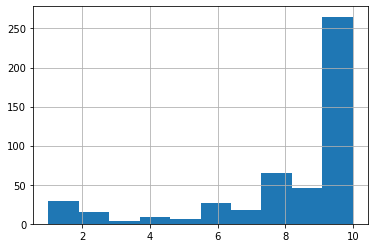

In [ ]:
df.score.hist()

In [ ]:
# 영화 평점 : 8.59
# score가 평균보다 높으면 긍정적인 반응으로 보고 평균보다 낮으면 부정적인 반응으로 보았습니다.
# score 데이터 이진 변환

def rating_to_label(rating):
    if rating > 8:
        return 1
    else:
        return 0

df['is_positive'] = df['score'].apply(lambda x: rating_to_label(x))

In [ ]:
df.head()

,score,comment,is_positive
0,10,다음장면이 예상 가는데도 불구하고 상황이 빠르게 흘러가다 보니 긴장감이 넘칩니다.잔...,1
1,10,긴장감 최고요~~~어김없이 다음편도 살짝 보여줍니다. 3펀기대기대요,1
2,10,나였으면 시작하자 마자 죽었을 듯...새로운 인물의 출연이 몰입도를 깨는 일은 없다...,1
3,10,스릴러는 이렇게 만드는거지. 영화 끝날 때까지 끝난게아님. 이거 이스케이프룸1 안보...,1
4,10,속도감있어서 끝까지 시간가는줄 모르고 봤어요. 끝나고 화장실갔는데 화장실문이 안 열...,1


In [ ]:
df.is_positive.value_counts()

1    311
0    171
Name: is_positive, dtype: int64

### 1.4.2 학습 및 테스트 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

y = df['is_positive']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size=0.3)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(337, 854)
(145, 854)


### 1.4.3 모델 학습

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train LR model
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# classifiacation predict
y_pred = lr.predict(x_test)

### 1.4.4 모델 학습 결과 평가

In [ ]:
# accuracy: 정확도 => 올바르게 예측된 데이터의 수를 전체 데이터의 수로 나눈 값 (TP+TN)/Total
# precision: 정밀도 => 실제로 True인 데이터를 모델이 True라고 인식한 데이터의 수 TP/(TP+FP)
# recall: 재현율 => 모델이 True라고 예측한 데이터 중 실제로 True인 데이터의 수 TP/(TP+FN)
# f1 score => precision과 recall의 조화평균. precision과 recall이 0 에 가까울수록 F1 score도 동일하게 낮은 값을 갖도록 하기 위해 조화평균 사용.

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("precision : %.3f" % precision_score(y_test, y_pred))
print("recall : %.3f" % recall_score(y_test, y_pred))
print("f1_score : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.63
precision : 0.624
recall : 0.989
f1_score : 0.765


## 1.5 모델 학습 결과 분석

### 1.5.1 로지스틱 회귀 모델의 coef 값 분석

In [ ]:
lr.coef_[0]

array([ 0.        ,  0.0986012 ,  0.12386227,  0.16072858,  0.11013399,
       -0.03479795,  0.138804  , -0.24602072,  0.23238263,  0.        ,
       -0.6506444 , -0.10373626, -0.41746345, -0.0432472 ,  0.        ,
       -0.25237078,  0.41131847, -0.34443982,  0.        , -0.06948453,
        0.07614746, -0.20414662,  0.        ,  0.44935853,  0.25946445,
        0.1121279 ,  0.35051317,  0.28970112, -0.10436239,  0.83778966,
        0.07614746,  0.15315138, -0.13854195,  0.        ,  0.        ,
        0.17954473,  0.        ,  0.11663171, -0.10068522, -0.10575719,
        0.11745828,  0.05290038,  0.        ,  0.        ,  0.08554003,
        0.        , -0.0461724 , -0.17692358, -0.22162323,  0.16913242,
       -0.22162323, -0.1996269 ,  0.        , -0.21734226,  0.        ,
        0.35278357,  0.08332506, -0.12331162, -0.16944969, -0.1996269 ,
       -0.15033075,  0.04148716, -0.30326646, -0.16948078, -0.1392819 ,
        0.        , -0.25339364, -0.22259265,  0.13758618,  0.  

<BarContainer object of 854 artists>

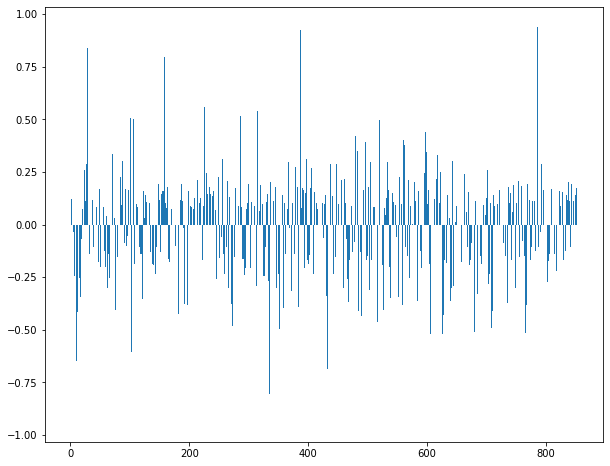

In [ ]:
# print logistic regression's coef
# 길이가 짧은 선은 긍정과 부정 모두에 나타나는 단어

plt.figure(figsize=(10,8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

### 1.5.2 긍정/부정 키워드 출력

In [ ]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.940584559572163, 786), (0.9261702614398466, 387), (0.8377896558674793, 29), (0.7948322834050757, 158), (0.6217745971019619, 661)]
[(-0.6506443963467083, 10), (-0.685707547670786, 433), (-0.7486746913798926, 795), (-0.8075613584684053, 335), (-0.9386107449766584, 767)]


In [ ]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)
coef_pos_index

[(0.940584559572163, 786),
 (0.9261702614398466, 387),
 (0.8377896558674793, 29),
 (0.7948322834050757, 158),
 (0.6217745971019619, 661),
 (0.5590026192043746, 226),
 (0.5375189590739916, 315),
 (0.5268589613456879, 82),
 (0.5169138495600549, 286),
 (0.5119500025514564, 420),
 (0.509066581721307, 370),
 (0.5088072526190207, 101),
 (0.5037018694799296, 106),
 (0.49560954287250525, 520),
 (0.4576714275315792, 117),
 (0.4493585322188657, 23),
 (0.4414562649361813, 807),
 (0.44035862971271084, 598),
 (0.4258024364091284, 696),
 (0.42326501330525235, 480),
 (0.4203196289549977, 642),
 (0.41691159918306053, 627),
 (0.41131847000397687, 16),
 (0.40402960557684003, 561),
 (0.3934306486526166, 435),
 (0.3933280655996665, 497),
 (0.3780585648843287, 562),
 (0.35278357085310064, 55),
 (0.35165511919051656, 849),
 (0.35051317349880223, 26),
 (0.3482284020754889, 483),
 (0.3441119165060469, 599),
 (0.34288014127362615, 528),
 (0.3401398766274815, 400),
 (0.33334299392104255, 71),
 (0.32835643798110

In [ ]:
# {벡터:단어} 맵핑
# vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
vector_word_dictionary = {v: k for k, v in vect.vocabulary_.items()}

In [ ]:
vector_word_dictionary

{0: '가기',
 1: '가능',
 2: '가면',
 3: '가미',
 4: '가쁠',
 5: '가세',
 6: '가속',
 7: '가속도',
 8: '가슴',
 9: '가슴골',
 10: '가장',
 11: '각본',
 12: '간다',
 13: '간만',
 14: '갈고',
 15: '갈수록',
 16: '감독',
 17: '감동',
 18: '감상',
 19: '감전',
 20: '감탄',
 21: '갑자기',
 22: '갑툭튀',
 23: '강추',
 24: '개꿀잼',
 25: '개미',
 26: '개봉',
 27: '개불',
 28: '개연',
 29: '개인',
 30: '개천',
 31: '거리',
 32: '거의',
 33: '거임',
 34: '거중',
 35: '거지',
 36: '거치',
 37: '걱정',
 38: '건가',
 39: '게임',
 40: '격방',
 41: '결말',
 42: '경찰',
 43: '경찰서',
 44: '경향',
 45: '계단',
 46: '계속',
 47: '고민',
 48: '골도',
 49: '공간',
 50: '공감',
 51: '공상',
 52: '공짜',
 53: '공포',
 54: '공포물',
 55: '공포영화',
 56: '공항',
 57: '과거',
 58: '과연',
 59: '과학',
 60: '관객',
 61: '관람',
 62: '관람객',
 63: '구경',
 64: '구나',
 65: '구상',
 66: '구성',
 67: '구성은',
 68: '구합',
 69: '군더더기',
 70: '굳이',
 71: '굿굿',
 72: '굿잼',
 73: '궁금',
 74: '권장',
 75: '그게',
 76: '그냥',
 77: '그다음',
 78: '그닥',
 79: '그대로',
 80: '그로',
 81: '극도',
 82: '극장',
 83: '극찬',
 84: '극한',
 85: '근래',
 86: '금방',
 87: '기다림',
 88: '기대',
 89: '기두',
 90

In [ ]:
for coef in coef_pos_index[:10]:
    print(vector_word_dictionary[coef[1]], coef[0])

편도 0.940584559572163
소름 0.9261702614398466
개인 0.8377896558674793
대박 0.7948322834050757
존잼 0.6217745971019619
마지막 0.5590026192043746
보고 0.5375189590739916
극장 0.5268589613456879
바로 0.5169138495600549
시간 0.5119500025514564


In [ ]:
for coef in coef_neg_index[:10]:
    print(vector_word_dictionary[coef[1]], coef[0])

킬링타임 -0.9386107449766584
부분 -0.8075613584684053
평점 -0.7486746913798926
실망 -0.685707547670786
가장 -0.6506443963467083
노잼 -0.6359250582114032
흥미 -0.6297146547201656
나름 -0.6047343318103284
억지 -0.5993287915739011
생존 -0.5869261967626468


### 1.5.3 마무리

별점을 높게 매긴 관객과 낮게 매긴 관객들은 각각 사용하는 단어에서 차이점을 보였습니다.<br>
긍정적인 반응을 보인 관객들의 경우 ‘편도’, ‘대박’, ‘소름’, ‘최고’, ‘존잼’ 등의 단어를 사용하는 모습이 나타났습니다.<br>
‘편도’의 경우 지난 작품인 1편에 이어서 이번 작품도 재미있었다는 반응과, 후속작으로 나올 3편이 기대된다는 반응에서
모두 사용된 단어입니다.<br> 전작을 보고 온 관객들의 만족도가 높았던 점과 더불어 이번 작품을 긍정적으로 평가한 관객들은
후속작도 보러 갈 의사가 있음을 알 수 있습니다.<br>
긍정적으로 분류된 다른 단어들은 스토리 전개와 구성에 만족감을 표현하는 단어들이었습니다.<br>
한편, ‘전개’와 ‘편의’라는 단어를 사용한 관객들은 부정적인 반응을 보였습니다.<br>
스토리 전개가 기대 이하였다는 반응과 함께, 이번 작품은 지난 작품에 비해 재미없었다는 반응이 나타났습니다.<br>
미시적인 관점에서 이번 작품의 개별적인 장면들에 집중했던 관객들은 만족도가 높았던 반면, <br>
거시적인 관점에서 지난 작품과의 연결성 및 영화가 전달하는 메시지를 중시하는 관객들은 만족도가 낮았던 것으로 보입니다.